Adding PDFs
====

Investigation into using a PDF to describe the combination of multiple distributions.

In [1]:
# Just some boilerplate code

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

rng = np.random.default_rng()
pdf_domain = (-3, 7)
pdf_range = (0, 1.0)


def sample(N, pdf, pdf_domain, pdf_range):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points

Consider two Gaussians $x_1$ and $x_2$ and their sum $x_3 = x_1 + x_2$:

In [ ]:
# Define two slightly different Gaussian PDFs
# These aren't normalised on purpose
std_normal_pdf = lambda x: 1.2 * norm.pdf(x, loc=0, scale=1)
shifted_normal_pdf = lambda x: 0.9 * norm.pdf(x, loc=3, scale=1)

# Generate N1 points from one Gaussian and N2 points from the other
N1, N2 = 10000, 5000
x1 = sample(N1, std_normal_pdf, pdf_domain, pdf_range)
x2 = sample(N2, shifted_normal_pdf, pdf_domain, pdf_range)

# Plot histograms
kw = {"histtype": "step", "bins": np.linspace(*pdf_domain, 50), "alpha": 0.8}
plt.hist(x1, **kw, label=r"$x_1$")
plt.hist(x2, **kw, label=r"$x_2$")
plt.hist(np.concatenate((x1, x2)), **kw, label=r"$x_1+x_2$")
plt.title("Samples")
plt.legend()
plt.show()

What PDF describes the combination $x_3 = x_1 + x_2$?

Hypothesis- the combined PDF is:

$p(x) = I_1p_1(x) + I_2p_2(x)$

Where:

$I_j = \sum_{i=0}^{N_j}\frac{1}{p_j(x_i)}$


10000 5000


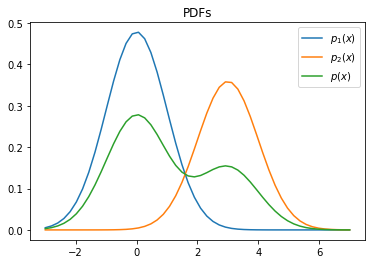

In [6]:
I1 = 0
I2 = 0

# Iterate over all of the points
for p in x1:
    I1 += 1 / std_normal_pdf(p)
for p in x2:
    I2 += 1 / shifted_normal_pdf(p)

# Scale the integrals to something more sensible
sf = I1 + I2
I1 /= sf
I2 /= sf

print(len(x1), len(x2))

combined_pdf = lambda x: I1 * std_normal_pdf(x) + I2 * shifted_normal_pdf(x)

points = np.linspace(*pdf_domain)
pdf1 = [std_normal_pdf(x) for x in points]
pdf2 = [shifted_normal_pdf(x) for x in points]
pdf3 = [combined_pdf(x) for x in points]

plt.plot(points, pdf1, label=r"$p_1(x)$")
plt.plot(points, pdf2, label=r"$p_2(x)$")
plt.plot(points, pdf3, label=r"$p(x)$")
plt.title("PDFs")
plt.legend()

plt.show()

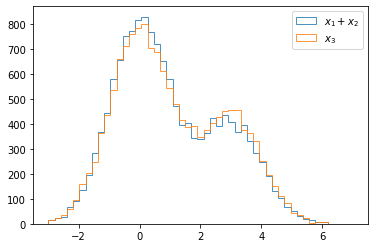

In [7]:
# Generate a sample from the combined PDF
x3 = sample(N1 + N2, combined_pdf, pdf_domain, pdf_range)

plt.hist(np.concatenate((x1, x2)), **kw, label=r"$x_1+x_2$")
plt.hist(x3, **kw, label=r"$x_3$")
plt.legend()
plt.show()

$\uparrow$ this does look right